# CenterNet


In [8]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from ROI.centernet import CenterNet, init_weights
from ROI.dataset import (
    RoiDataset,
    generate_padded_dataset, generate_resized_dataset,
    generate_bbox_csv, generate_cropped_dataset)
from ROI.train import fit
from ROI.helpers import *
from ROI.losses import CenterLoss

## Prepare dataset for training

- Pad high resolution images to square shapes
- Resize padded images to 512x512
- Generate dataframe with bounding boxes for optic discs
- Split dataset into training and validation sets


In [2]:
ORIGA_DIR = '../data/ORIGA'
CSV_FILE = ORIGA_DIR + '/origa.csv'

In [3]:
generate_padded_dataset(
    src_images_dir=ORIGA_DIR + '/Images',
    src_masks_dir=ORIGA_DIR + '/Masks',
    dst_images_dir=ORIGA_DIR + '/Images_Padded',
    dst_masks_dir=ORIGA_DIR + '/Masks_Padded',
)

100%|██████████| 650/650 [06:46<00:00,  1.60it/s]


In [4]:
generate_resized_dataset(
    src_images_dir=ORIGA_DIR + '/Images_Padded',
    src_masks_dir=ORIGA_DIR + '/Masks_Padded',
    dst_images_dir=ORIGA_DIR + '/Images_512x512',
    dst_masks_dir=ORIGA_DIR + '/Masks_512x512',
    size=512,
)

100%|██████████| 650/650 [03:31<00:00,  3.07it/s]


In [12]:
generate_bbox_csv(
    images_dir=ORIGA_DIR + '/Images_512x512',
    masks_dir=ORIGA_DIR + '/Masks_512x512',
    csv_file=CSV_FILE,
    margin=0,
)

  0%|          | 0/650 [00:00<?, ?it/s]

In [13]:
df = pd.read_csv(CSV_FILE)
image_ids = df['image_id'].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=411)

print('Training size:', len(train_ids))
print('Validation size:', len(val_ids))

df.head()

Training size: 520
Validation size: 130


,image_id,mask_id,x,y,w,h
0,..\data\ORIGA\Images_512x512\001.jpg,..\data\ORIGA\Masks_512x512\001.png,276.0,215.0,77.0,94.0
1,..\data\ORIGA\Images_512x512\002.jpg,..\data\ORIGA\Masks_512x512\002.png,179.0,185.0,72.0,91.0
2,..\data\ORIGA\Images_512x512\003.jpg,..\data\ORIGA\Masks_512x512\003.png,163.0,203.0,80.0,84.0
3,..\data\ORIGA\Images_512x512\004.jpg,..\data\ORIGA\Masks_512x512\004.png,298.0,218.0,66.0,75.0
4,..\data\ORIGA\Images_512x512\005.jpg,..\data\ORIGA\Masks_512x512\005.png,154.0,211.0,75.0,79.0


## Train model

In [14]:
# Hyper-parameters
MODEL_PATH = r'C:\Users\kappe\PycharmProjects\DP-GlaucomaSegmentation\notebooks\centernet_resnet18.pth'
INPUT_SIZE = 512
IN_SCALE = 512 // INPUT_SIZE
MODEL_SCALE = 4
BATCH_SIZE = 2
MODEL_NAME = 'resnet18'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


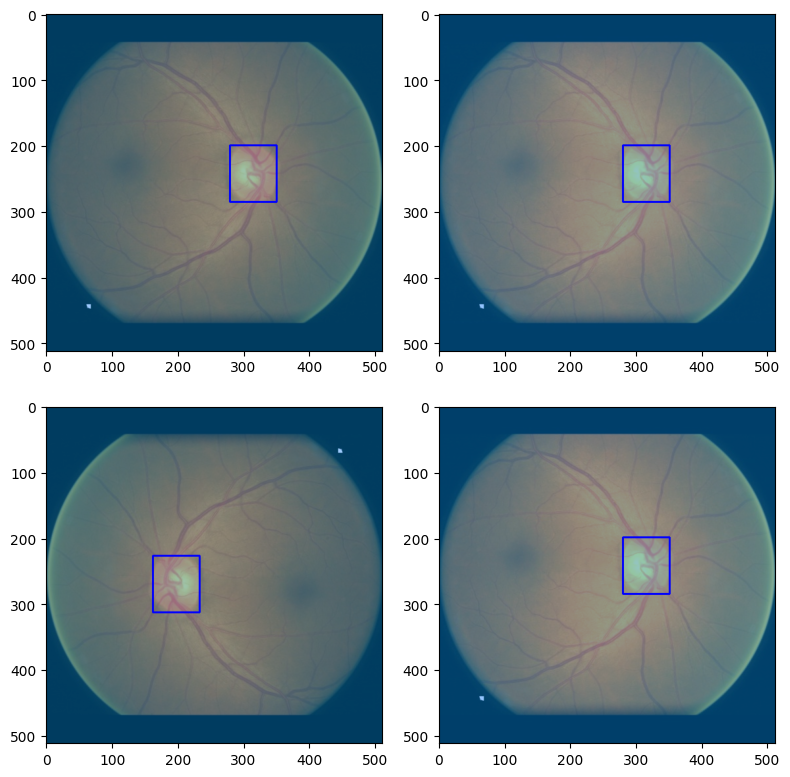

In [15]:
train_transform = A.Compose([
    A.Resize(INPUT_SIZE, INPUT_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.9400, 0.6225, 0.3316), std=(0.1557, 0.1727, 0.1556)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

val_transform = A.Compose([
    A.Resize(INPUT_SIZE, INPUT_SIZE),
    A.Normalize(mean=(0.9400, 0.6225, 0.3316), std=(0.1557, 0.1727, 0.1556)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

res = []
dataset = RoiDataset(train_ids, df, INPUT_SIZE, IN_SCALE, MODEL_SCALE, train_transform)
for i in range(4):
    img, heatmap, regression, bboxes, *_ = dataset[0]
    img = (img - img.min()) / (img.max() - img.min())
    img = img.permute(1, 2, 0).numpy()
    for bbox in bboxes:
        x, y, w, h = bbox
        x, y, w, h = int(x), int(y), int(w), int(h)
        img = cv.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
    res.append(img)

_, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i, img in enumerate(res):
    ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [16]:
train_dataset = RoiDataset(train_ids, df, INPUT_SIZE, IN_SCALE, MODEL_SCALE, train_transform)
val_dataset = RoiDataset(val_ids, df, INPUT_SIZE, IN_SCALE, MODEL_SCALE, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [22]:
model = CenterNet()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = CenterLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)

if MODEL_PATH:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print('Model loaded from', MODEL_PATH)
else:
    init_weights(model)
model = model.to(DEVICE)

Model loaded from C:\Users\kappe\PycharmProjects\DP-GlaucomaSegmentation\notebooks\centernet_resnet18.pth


In [ ]:
hist = fit(model, optimizer, criterion, DEVICE, train_loader, val_loader, epochs=10)
print([k for k in hist.keys()])

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(hist['train_loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')

# Show predictions

In [49]:
margin = 16
res = pd.DataFrame()

for i, (imgs, heatmap_gt, regression_gt, boxes_gt, img_files, mask_files) in enumerate(val_loader):
    # if i > 5:
    #     break

    imgs = imgs.to(DEVICE)
    with torch.no_grad():
        heatmap, regression = model(imgs)

    for img, hm, regr, gt_box, img_file, mask_file in zip(imgs, heatmap, regression, boxes_gt, img_files, mask_files):

        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        img = (img * 255).astype(np.uint8)
        hm = hm.squeeze()
        regr = regr.cpu().numpy()
        gt_box = gt_box.cpu().numpy()

        hm = torch.sigmoid(hm).cpu().numpy()
        hm = pool_duplicates(hm)
        bboxes, scores = prediction_to_bboxes(hm, regr, INPUT_SIZE, MODEL_SCALE, 0.6)
        if len(bboxes) == 0:
            print('No boxes found for image', i)
            continue
        merged_box = merge_overlapping_boxes(bboxes, scores, 0.5)

        for box in gt_box:
            x, y, w, h = box
            x, y, w, h = int(x), int(y), int(w), int(h)
            img = cv.rectangle(img.copy(), (x, y), (x + w, y + h), (0, 255, 0), 1)

        cov = 0
        if merged_box is not None:
            # Add margin to merged box
            x, y, w, h = merged_box
            x = int(max(0, x - margin))
            y = int(max(0, y - margin))
            w = int(min(INPUT_SIZE, w + 2 * margin))
            h = int(min(INPUT_SIZE, h + 2 * margin))
            x, y, w, h = resize_to_square([x, y, w, h])

            img = cv.rectangle(img.copy(), (x, y), (x + w, y + h), (0, 0, 0), 1)
            cov = calculate_coverage(gt_box[0], [x, y, w, h])

            row = {
                'image_id': img_file,
                'mask_id': mask_file,
                'x': x,
                'y': y,
                'w': w,
                'h': h,
                'coverage': cov,
            }
            res = pd.concat([res, pd.DataFrame([row])])

            img = cv.putText(img.copy(), f'{cov:.2f}', (20, 40), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        if cov < 1.0:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            plt.imshow(img)
            plt.title(img_file)
            plt.show()


No boxes found for image 64


,image_id,mask_id,x,y,w,h,coverage
0,..\data\ORIGA\Images_512x512\422.jpg,..\data\ORIGA\Masks_512x512\422.png,112,179,120,120,1.0
0,..\data\ORIGA\Images_512x512\532.jpg,..\data\ORIGA\Masks_512x512\532.png,182,196,108,108,1.0
0,..\data\ORIGA\Images_512x512\110.jpg,..\data\ORIGA\Masks_512x512\110.png,231,180,118,118,1.0
0,..\data\ORIGA\Images_512x512\527.jpg,..\data\ORIGA\Masks_512x512\527.png,246,180,116,116,1.0
0,..\data\ORIGA\Images_512x512\437.jpg,..\data\ORIGA\Masks_512x512\437.png,138,193,115,115,1.0
...,...,...,...,...,...,...,...
0,..\data\ORIGA\Images_512x512\055.jpg,..\data\ORIGA\Masks_512x512\055.png,286,192,117,117,1.0
0,..\data\ORIGA\Images_512x512\289.jpg,..\data\ORIGA\Masks_512x512\289.png,262,185,119,119,1.0
0,..\data\ORIGA\Images_512x512\499.jpg,..\data\ORIGA\Masks_512x512\499.png,244,202,120,120,1.0
0,..\data\ORIGA\Images_512x512\481.jpg,..\data\ORIGA\Masks_512x512\481.png,263,204,116,116,1.0


In [64]:
generate_cropped_dataset(
    res,
    src_images_dir=ORIGA_DIR + '/Images_Padded',
    src_masks_dir=ORIGA_DIR + '/Masks_Padded',
    dst_images_dir=ORIGA_DIR + '/Images_CenterNet_Cropped',
    dst_masks_dir=ORIGA_DIR + '/Masks_CenterNet_Cropped',
    size=512,
)

  0%|          | 0/129 [00:00<?, ?it/s]